# Introduction to gQuant

**gQuant** is a set of open-source examples for Quantitative Analysis tasks:
- Data preparation & feat. engineering
- Alpha seeking modeling
- Technical indicators
- Backtesting

It is GPU-accelerated by leveraging [**RAPIDS.ai**](https://rapids.ai) technology, and has Multi-GPU and Multi-Node support.

gQuant computing components are oriented around its plugins and task graph.

## Download example datasets

Before getting started, let's download the example datasets if not present.

In [1]:
! ((test ! -f './data/stock_price_hist.csv.gz' ||  test ! -f './data/security_master.csv.gz') && \
  cd .. && bash download_data.sh) || echo "Dataset is already present. No need to re-download it."

Dataset is already present. No need to re-download it.


## About this notebook

In this tutorial, we are going to use gQuant to do a simple quant job. The job tasks are listed below:
    1. load csv stock data.
    2. filter out the stocks that has average volume smaller than 50.
    3. sort the stock symbols and datetime.
    4. add rate of return as a feature into the table.
    5. in two branches, computethe mean volume and mean return.
    6. read the file containing the stock symbol names, and join the computed dataframes.
    7. output the result in csv files.
    
## TaskGraph playground

Run the following gquant code to start a empty TaskGraph where computation graph can be created. You can follow the steps as listed below.

In [2]:
import sys; sys.path.insert(0, '..')
from gquant.dataframe_flow import TaskGraph
task_graph = TaskGraph()
task_graph.draw()

GQuantWidget(sub=HBox())

## Step by Step to build your first task graph

### Create Task node to load the included stock csv file 
<img src="images/loader_csv.gif" align="center">

### Explore the data and visualize it
<img src='images/explore_data.gif' align='center'>

### Clean up the Task nodes for next steps
<img src='images/clean.gif' align='center'>

### Filter the data and compute the rate of return feature
<img src='images/get_return_feature.gif' align='center'>

### Save current TaskGraph for a composite Task node
<img src='images/add_composite_node.gif' align='center'>

### Clean up the redudant feature computation Task nodes
<img src='images/clean_up_feature.gif' align='center'>

### Compute the averge volume and returns 
<img src='images/average.gif' align='center'>

### Dump the dataframe to csv files
<img src='images/csv_out.gif' align='center'>

Just in case you cannnot follow along, here you can load the tutorial taskgraph from the file. First one is the graph to calculate the return feature. 

In [3]:
task_graph = TaskGraph.load_taskgraph('../taskgraphs/get_return_feature.gq.yaml')
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

Load the full graph and click on the `run` button to see the result

In [4]:
task_graph = TaskGraph.load_taskgraph('../taskgraphs/tutorial_intro.gq.yaml')
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

## About Task graphs, nodes and plugins

Quant processing operators are defined as nodes that operates on **cuDF**/**dask_cuDF** dataframes.

A **task graph** is a list of tasks composed of gQuant nodes.

The cell below contains the task graph described before.

In [5]:
import warnings; warnings.simplefilter("ignore")
csv_average_return = 'average_return.csv'
csv_average_volume = 'average_volume.csv'
csv_file_path = './data/stock_price_hist.csv.gz'
csv_name_file_path = './data/security_master.csv.gz'
from gquant.dataframe_flow import TaskSpecSchema 

# load csv stock data
task_csvdata = {
    TaskSpecSchema.task_id: 'stock_data',
    TaskSpecSchema.node_type: 'CsvStockLoader',
    TaskSpecSchema.conf: {'file': csv_file_path},
    TaskSpecSchema.inputs: {}
}

# filter out the stocks that has average volume smaller than 50
task_minVolume = {
    TaskSpecSchema.task_id: 'volume_filter',
    TaskSpecSchema.node_type: 'ValueFilterNode',
    TaskSpecSchema.conf: [{'min': 50.0, 'column': 'volume'}],
    TaskSpecSchema.inputs: {'in': 'stock_data.cudf_out'}
}

# sort the stock symbols and datetime
task_sort = {
    TaskSpecSchema.task_id: 'sort_node',
    TaskSpecSchema.node_type: 'SortNode',
    TaskSpecSchema.conf: {'keys': ['asset', 'datetime']},
    TaskSpecSchema.inputs: {'in': 'volume_filter.out'}
}

# add rate of return as a feature into the table
task_addReturn = {
    TaskSpecSchema.task_id: 'add_return_feature',
    TaskSpecSchema.node_type: 'ReturnFeatureNode',
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: {'stock_in': 'sort_node.out'}
}

# read the stock symbol name file and join the computed dataframes
task_stockSymbol = {
    TaskSpecSchema.task_id: 'stock_name',
    TaskSpecSchema.node_type: 'StockNameLoader',
    TaskSpecSchema.conf: {'file': csv_name_file_path },
    TaskSpecSchema.inputs: {}
}

# In two branches, compute the mean volume and mean return seperately
task_volumeMean = {
    TaskSpecSchema.task_id: 'average_volume',
    TaskSpecSchema.node_type: 'AverageNode',
    TaskSpecSchema.conf: {'column': 'volume'},
    TaskSpecSchema.inputs: {'stock_in': 'add_return_feature.stock_out'}
}

task_returnMean = {
    TaskSpecSchema.task_id: 'average_return',
    TaskSpecSchema.node_type: 'AverageNode',
    TaskSpecSchema.conf: {'column': 'returns'},
    TaskSpecSchema.inputs: {'stock_in': 'add_return_feature.stock_out'}
}

task_leftMerge1 = {
    TaskSpecSchema.task_id: 'left_merge1',
    TaskSpecSchema.node_type: 'LeftMergeNode',
    TaskSpecSchema.conf: {'column': 'asset'},
    TaskSpecSchema.inputs: {'left': 'average_return.stock_out', 
                            'right': 'stock_name.stock_name'}
}

task_leftMerge2 = {
    TaskSpecSchema.task_id: 'left_merge2',
    TaskSpecSchema.node_type: 'LeftMergeNode',
    TaskSpecSchema.conf: {'column': 'asset'},
    TaskSpecSchema.inputs: {'left': 'average_volume.stock_out', 
                            'right': 'stock_name.stock_name'}
}

# output the result in csv files

task_outputCsv1 = {
    TaskSpecSchema.task_id: 'output_csv1',
    TaskSpecSchema.node_type: 'OutCsvNode',
    TaskSpecSchema.conf: {'path': csv_average_return},
    TaskSpecSchema.inputs: {'df_in': 'left_merge1.merged'}
}

task_outputCsv2 = {
    TaskSpecSchema.task_id: 'output_csv2',
    TaskSpecSchema.node_type: 'OutCsvNode',
    TaskSpecSchema.conf: {'path': csv_average_volume },
    TaskSpecSchema.inputs: {'df_in': 'left_merge2.merged'}
}

In Python, a gQuant task-spec is defined as a dictionary with the following fields:
- `id`
- `type`
- `conf`
- `inputs`
- `filepath`
- `module`

As a best practice, we recommend using the `TaskSpecSchema` class for these fields, instead of strings.

The `id` for a given task must be unique within a task graph. To use the result(s) of other task(s) as input(s) of a different task, we use the id(s) of the former task(s) in the `inputs` field of the next task.

The `type` field contains the node type to use for the compute task. gQuant includes a collection of node classes. These can be found in `gquant.plugin_nodes`. Click [here](#node_class_example) to see a gQuant node class example.

The `conf` field is used to parameterise a task. It lets you access user-set parameters within a plugin (such as `self.conf['min']` in the example above). Each node defines the `conf` json schema. The gQuant UI can use this schema to generate the proper form UI for the inputs. It is recommended to use the UI to configure the `conf`. 

The `filepath` field is used to specify a python module where a custom plugin is defined. It is optional if the plugin is in `plugin_nodes` directory, and mandatory when the plugin is somewhere else. In a different tutorial, we will learn how to create custom plugins.

The `module` is optional to tell gQuant the name of module that the node type is from. If it is not specified, gQuant will search for it among all the customized modules. 

A custom node schema will look something like this:
```
custom_task = {
    TaskSpecSchema.task_id: 'custom_calc',
    TaskSpecSchema.node_type: 'CustomNode',
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: ['some_other_node'],
    TaskSpecSchema.filepath: 'custom_nodes.py'
}
```

Below, we compose our task graph and visualize it as a graph.

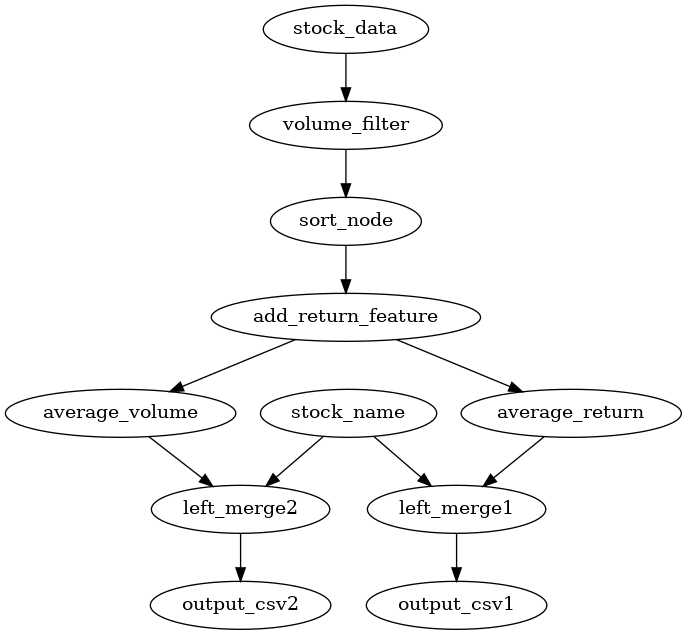

In [6]:
from gquant.dataframe_flow import TaskGraph

# list of nodes composing the task graph
task_list = [
    task_csvdata, task_minVolume, task_sort, task_addReturn,
    task_stockSymbol, task_volumeMean, task_returnMean,
    task_leftMerge1, task_leftMerge2,
    task_outputCsv1, task_outputCsv2]

task_graph = TaskGraph(task_list)
task_graph.draw(show='ipynb')

We can visualize the ports by setting `show_ports` to `True`

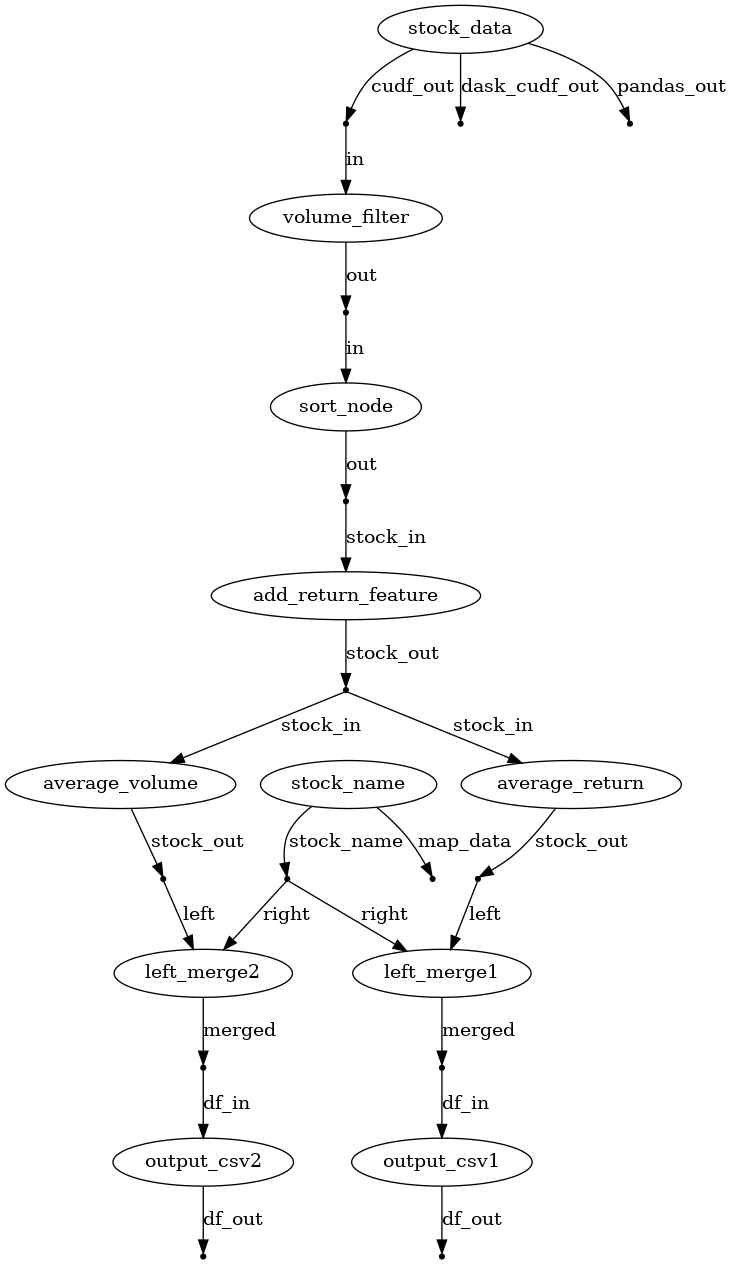

In [7]:
task_graph.draw(show='ipynb', show_ports=True)

It is recommended to visualize it with gQuant widget so you can interact with it by call `draw` without arguments

In [8]:
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

We will use `save_taskgraph` method to save the task graph to a **yaml file**.

That will allow us to re-use it in the future.

In [9]:
task_graph_file_name = '01_tutorial_task_graph.gq.yaml'

task_graph.save_taskgraph(task_graph_file_name)

Here is a snippet of the content in the resulting yaml file:

In [10]:
%%bash -s "$task_graph_file_name"
head -n 19 $1

- id: stock_data
  type: CsvStockLoader
  conf:
    file: ./data/stock_price_hist.csv.gz
  inputs: {}
- id: volume_filter
  type: ValueFilterNode
  conf:
  - column: volume
    min: 50
  inputs:
    in: stock_data.cudf_out
- id: sort_node
  type: SortNode
  conf:
    keys:
    - asset
    - datetime
  inputs:


The yaml file describes the computation tasks.  We can load it and visualize it as a graph.

In [11]:
task_graph = TaskGraph.load_taskgraph(task_graph_file_name)
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

## Building a task graph

Running the task graph is the next logical step. Nevertheless, it can optionally be built before running it.

By calling `build` method, the graph is traversed without running the dataframe computations. This could be useful to inspect the column names and types, validate that the plugins can be instantiated, and check for errors.

The output of `build` are instances of each task in a dictionary.

In the example below, we inspect the column names and types for the inputs and outputs of the `left_merge1` task:

In [12]:
from pprint import pprint

task_graph.build()

print('Output of build task graph are instances of each task in a dictionary:\n')
print(str(task_graph))

Output of build task graph are instances of each task in a dictionary:

stock_data: <NodeInTaskGraph gquant.plugin_nodes.dataloader.csvStockLoader.CsvStockLoader object at 0x7fb4b66de250>
volume_filter: <NodeInTaskGraph gquant.plugin_nodes.transform.valueFilterNode.ValueFilterNode object at 0x7fb62928b950>
sort_node: <NodeInTaskGraph gquant.plugin_nodes.transform.sortNode.SortNode object at 0x7fb62928b050>
add_return_feature: <NodeInTaskGraph gquant.plugin_nodes.transform.returnFeatureNode.ReturnFeatureNode object at 0x7fb62928e210>
stock_name: <NodeInTaskGraph gquant.plugin_nodes.dataloader.stockNameLoader.StockNameLoader object at 0x7fb62928ea10>
average_volume: <NodeInTaskGraph gquant.plugin_nodes.transform.averageNode.AverageNode object at 0x7fb6292b3f50>
average_return: <NodeInTaskGraph gquant.plugin_nodes.transform.averageNode.AverageNode object at 0x7fb638139e50>
left_merge1: <NodeInTaskGraph gquant.plugin_nodes.transform.leftMergeNode.LeftMergeNode object at 0x7fb629292690>
lef

In [13]:
# Output columns in 'left_merge_1' node

print('Output columns in outgoing dataframe:\n')
pprint(task_graph['left_merge1'].columns_setup())

Output columns in outgoing dataframe:

{'merged': {'asset': 'int64', 'asset_name': 'object', 'returns': 'float64'}}


## Running a task graph

To execute the graph computations, we will use the `run` method. If the `Output_Collector` task node is not added to the graph, a output list can be feeded to the run method. The result can be displayed in a rich mode if the `formated` argument is turned on.

`run` can also takes an optional `replace` argument which is used and explained later on

In [14]:
outputs = ['stock_data.cudf_out', 'output_csv1.df_out', 'output_csv2.df_out']
task_graph.run(outputs=outputs, formated=True)

The result can be used as a tuple or dictionary.

In [15]:
result = task_graph.run(outputs=outputs)
csv_data_df, csv_1_df, csv_2_df = result
result['output_csv2.df_out']

,asset,volume,asset_name
0,869577,154.528596,CTT
1,869584,701.630560,LPT
2,869587,119.878161,HBP
3,869589,161.938559,DSLV
4,869590,204.126667,BPTH
...,...,...,...
4995,707588,99.917736,LDP
4996,707611,393.918500,LITB
4997,707619,112.800000,LND
4998,707624,1256.701650,LOCK


We can profile each of the computation node running time by turning on the profiler.

In [16]:
outputs =  ['stock_data.cudf_out', 'output_csv1.df_out', 'output_csv2.df_out']
csv_data_df, csv_1_df, csv_2_df = task_graph.run(outputs=outputs, profile=True)

id:stock_data process time:3.999s
id:volume_filter process time:0.009s
id:sort_node process time:0.089s
id:add_return_feature process time:0.057s
id:average_volume process time:0.035s
id:average_return process time:0.034s
id:stock_name process time:0.013s
id:left_merge1 process time:0.002s
id:output_csv1 process time:0.028s
id:left_merge2 process time:0.002s
id:output_csv2 process time:0.026s


Where most of the time is spent on the csv file processing. This is because we have to convert the time string to the proper format via CPU. Let's inspect the content of `csv_1_df` and `csv_2_df`.

In [17]:
print('csv_1_df content:')
print(csv_1_df)

print('\ncsv_2_df content:')
print(csv_2_df)   

csv_1_df content:
       asset   returns asset_name
0     869577 -0.000295        CTT
1     869584  0.000387        LPT
2     869587  0.027713        HBP
3     869589  0.001337       DSLV
4     869590  0.009657       BPTH
...      ...       ...        ...
4995  707588 -0.000049        LDP
4996  707611 -0.000967       LITB
4997  707619 -0.021890        LND
4998  707624  0.001069       LOCK
4999  707647  0.001011       LXFR

[5000 rows x 3 columns]

csv_2_df content:
       asset      volume asset_name
0     869577  154.528596        CTT
1     869584  701.630560        LPT
2     869587  119.878161        HBP
3     869589  161.938559       DSLV
4     869590  204.126667       BPTH
...      ...         ...        ...
4995    7438   80.495558        NQM
4996    7440   76.090120        NQP
4997    7441   86.637237        NQS
4998    7443  569.610747         NR
4999    7455   68.407921        NRT

[5000 rows x 3 columns]


Also, please notice that two resulting csv files has been created:
- average_return.csv
- average_volume.csv

In [18]:
print('\ncsv files created:')
!find . -iname "*symbol*" 


csv files created:


## Subgraphs

A nice feature of task graphs is that we can evaluate any **subgraph**. For instance, if you are only interested in the `average volume` result, you can run only the tasks which are relevant for that computation.

If we would not want to re-run tasks, we could also use the `replace` argument of the `run` function with a `load` option.

The `replace` argument needs to be a dictionary where each key is the task/node id. The values are a replacement task-spec dictionary (i.e. each key is a spec overload, and its value is what to overload with).

In the example below, instead of re-running the `stock_data` node to load a csv file into a `cudf` dataframe, we will use its dataframe output to load from it.

In [19]:
replace = {
    'stock_data': {
        'load': {
            'cudf_out': csv_data_df
        },
        'save': True
    }
}

(volume_mean_df, ) = task_graph.run(outputs=['average_volume.stock_out'],
                                    replace=replace)

print(volume_mean_df)

       asset      volume
0         93   86.594737
1        165   67.020000
2        239  128.835141
3        281   68.450000
4        592  110.333333
...      ...         ...
4995  869589  161.938559
4996  869590  204.126667
4997  869592  101.423675
4998  869597   81.298788
4999  869599   83.425988

[5000 rows x 2 columns]


As a convenience, we can save on disk the checkpoints for any of the nodes, and re-load them if needed. It is only needed to set the save option to `True`. This step will take a while depends on the disk IO speed.

In the example above, the `replace` spec directs `run` to save on disk for the `stock_data`. If `load` was boolean then the data would be loaded from disk presuming the data was saved to disk in a prior run.

The default directory for saving is `<current_workdir>/.cache/<node_id>.hdf5`.

`replace` is also used to override parameters in the tasks. For instance, if we wanted to use the value `40.0` instead `50.0` in the task `volume_filter`, we would do something similar to:
```
replace_spec = {
    'volume_filter': {
        'conf': {
            'min': 40.0
        }
    },
    'some_task': etc...
}
```

In [19]:
replace = {'stock_data': {'load': True},
           'average_return': {'save': True}}


(return_mean_df, ) = task_graph.run(outputs=['average_return.stock_out'], replace=replace)

print('Return mean Dataframe:\n')
print(return_mean_df)

Return mean Dataframe:

       asset   returns
0         93  0.241380
1        165  0.000700
2        239  0.010021
3        281 -0.088465
4        592  0.619716
...      ...       ...
4995  869589  0.001337
4996  869590  0.009657
4997  869592  0.001202
4998  869597 -0.003332
4999  869599  0.003291

[5000 rows x 2 columns]


Now, we might want to load the `return_mean_df` from the saved file and evaluate only tasks that we are interested in.

In the cells below, we compare different load approaches:
- in-memory,
- from disk, 
- and not loading at all.

When working interactively, or in situations requiring iterative and explorative task graphs, a significant amount of time is saved by just re-loading the data that do not require to be recalculated.

In [20]:
%%time
print('Using in-memory dataframes for load:')

replace = {'stock_data': {'load':  {
            'cudf_out': csv_data_df
            }},
           'average return': {'load': 
                              {'stock_out': return_mean_df}}
          }

_ = task_graph.run(outputs=['output_csv2.df_out'], replace=replace)

Using in-memory dataframes for load:
CPU times: user 319 ms, sys: 82.9 ms, total: 401 ms
Wall time: 397 ms


In [21]:
%%time
print('Using cached dataframes on disk for load:')

replace = {'stock_data': {'load': True},
           'average return': {'load': True}}

_ = task_graph.run(outputs=['output_csv2.df_out'], replace=replace)

Using cached dataframes on disk for load:
CPU times: user 4.14 s, sys: 932 ms, total: 5.08 s
Wall time: 5.06 s


In [22]:
%%time
print('Re-running dataframes calculations instead of using load:')

replace = {'stock_data': {'load': True}}

_ = task_graph.run(outputs=['output_csv2.df_out'], replace=replace)

Re-running dataframes calculations instead of using load:
CPU times: user 4.2 s, sys: 922 ms, total: 5.13 s
Wall time: 5.11 s


An idiomatic way to save data, if not on disk, or load data, if present on disk, is demonstrated below.

In [23]:
%%time
import os

loadsave_csv_data    = 'load' if os.path.isfile('./.cache/stock_data.hdf5') else 'save'
loadsave_return_mean = 'load' if os.path.isfile('./.cache/average_return.hdf5') else 'save'

replace = {'stock_data': {loadsave_csv_data: True},
           'average_return': {loadsave_return_mean: True}}

_ = task_graph.run(outputs=['output_csv2.df_out'], replace=replace)

CPU times: user 4.16 s, sys: 910 ms, total: 5.07 s
Wall time: 5.05 s


## Delete temporary files

A few cells above, we generated a .yaml file containing the example task graph, and also a couple of CSV files.

Let's keep our directory clean, and delete them.

In [24]:
%%bash -s "$task_graph_file_name"  "$csv_average_return" "$csv_average_volume" 
rm -f $1 $2 $3

<a id='node_class_example'></a>

---

## Node class example

Implementing custom nodes in gQuant is very straighforward.

Data scientists only need to override five methods in the parent class `Node`:
- `init`
- `columns_setup`
- `ports_setup`
- `conf_schema`
- `process`

`init` method is usually used to define the required column names

`ports_setup` defines the input and output ports for the node

`columns_setup` method is used to calculate the output column name and types.

`conf_schema` method is used to define the JSON schema for the node conf so the client can generate the proper UI for it.

`process` method takes input dataframes and computes the output dataframe. 

In this way, dataframes are strongly typed, and errors can be detected early before the time-consuming computation happens.

Below, it can be observed `ValueFilterNode` implementation details:

In [36]:
import inspect
from gquant.plugin_nodes.transform import ValueFilterNode

print(inspect.getsource(ValueFilterNode))

class ValueFilterNode(Node, _PortTypesMixin):

    def init(self):
        _PortTypesMixin.init(self)
        cols_required = {"asset": "int64"}
        self.required = {
            self.INPUT_PORT_NAME: cols_required
        }

    def columns_setup(self):
        return _PortTypesMixin.columns_setup(self)

    def ports_setup(self):
        return _PortTypesMixin.ports_setup(self)

    def conf_schema(self):
        json = {
            "title": "Value Filter Node configure",
            "type": "array",
            "description": """Filter the dataframe based on a list of
            min/max values.""",
            "items": {
                "type": "object",
                "properties": {
                    "column":  {
                        "type": "string",
                        "description": "dataframe column to be filered on"
                    },
                    "min": {
                        "type": "number",
                        "description": "min value, i